In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

/Users/juliasbardelatti/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
arquivos = [
    './2014.xls',
    './2015.xls',
    './2016.xls',
    './2017.xls',
    './2018.xls',
    './2019.xls',
    './2020.xls',
    './2021.xls',
    './2022.xls',
    './2023.xls',
    './2024.xls'
]

novos_nomes = ['regiao', 'codigo_uf', 'uf', 'codigo_ibge', 'municipio', 
               'qtd_magreza_acentuada', 'perc_magreza_acentuada',
               'qtd_magreza', 'perc_magreza',
               'qtd_eutrofia', 'perc_eutrofia',
               'qtd_sobrepeso', 'perc_sobrepeso',
               'qtd_obesidade', 'perc_obesidade',
               'qtd_obesidade_grave', 'perc_obesidade_grave', 'total']

In [3]:
relatorios = {}
df_list = []
for i, arquivo in enumerate(arquivos):
    ano = arquivo.split('/')[-1].split('.')[0]  
    
    tables = pd.read_html(arquivo)
    df = tables[0]  

    df = df.dropna(how='all')

    df.columns = novos_nomes
    df['ano'] = ano 
    relatorios[arquivo] = df
    df_list.append(df)
df_unido = pd.concat(df_list, ignore_index=True)

In [4]:
colunas_para_converter = ['perc_magreza_acentuada', 'perc_magreza', 'perc_eutrofia', 'perc_sobrepeso', 'perc_obesidade', 'perc_obesidade_grave'] 

for coluna in colunas_para_converter:
    df_unido[coluna] = df_unido[coluna].str.replace('%', '', regex=False) 
    df_unido[coluna] = pd.to_numeric(df_unido[coluna], errors='coerce') 
    df_unido[coluna] = df_unido[coluna] / 100 

In [5]:
df_unido.to_csv("e_sus.csv")

In [6]:
df_regioes = df_unido[df_unido['regiao'].str.startswith(('TOTAL REGIÃO', 'TOTAL BRASIL'), na=False)]
df_regioes['perc_total_obesidade'] = df_regioes['perc_sobrepeso'] + df_regioes['perc_obesidade'] + df_regioes['perc_obesidade_grave']
df_regioes = df_regioes[['regiao', 'perc_total_obesidade', 'ano']]

mapeamento = {
    'TOTAL REGIÃO CENTRO-OESTE': 'Centro-oeste',
    'TOTAL REGIÃO NORDESTE': 'Nordeste',
    'TOTAL REGIÃO NORTE': 'Norte',
    'TOTAL REGIÃO SUDESTE': 'Sudeste',
    'TOTAL REGIÃO SUL': 'Sul',
    'TOTAL BRASIL': 'Total Brasil'
}

df_regioes['regiao'] = df_regioes['regiao'].replace(mapeamento)

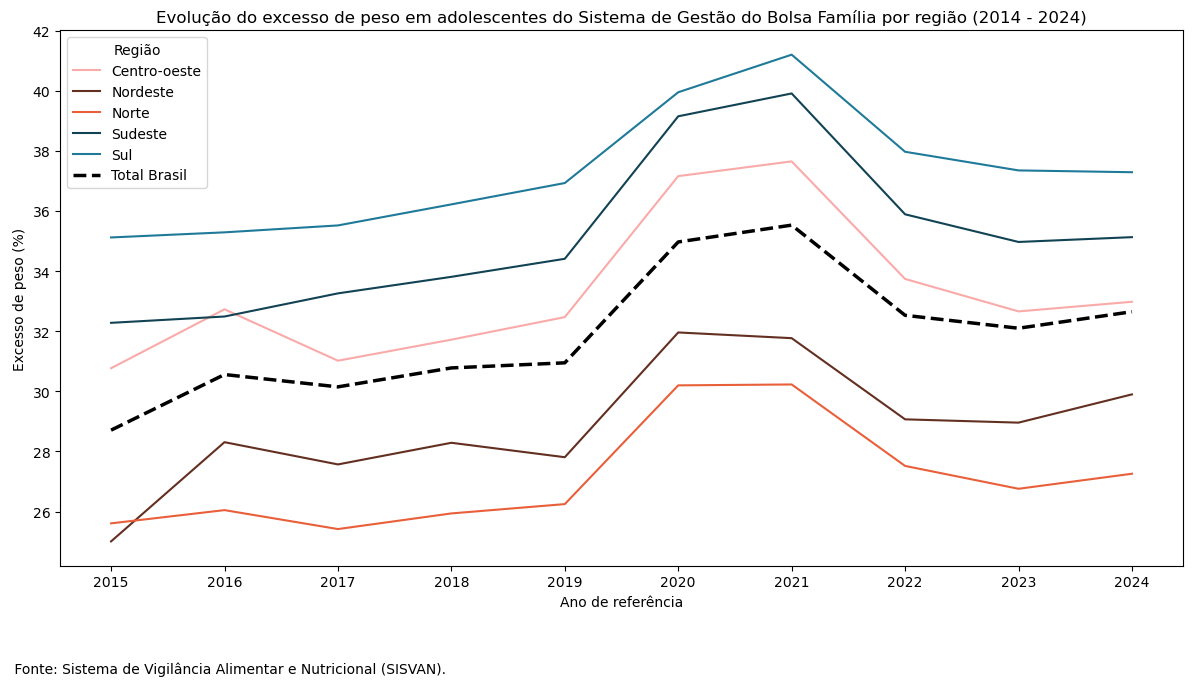

In [7]:
df_regioes.to_clipboard(decimal=",")
df_regioes['perc_total_obesidade'] = df_regioes['perc_total_obesidade'] * 100

plt.figure(figsize=(12, 7))  
cat_colors = ["#F9AAA9", "#632F21", "#E95F3A", "#114354", "#1F7A99"]
sns.set_palette(cat_colors)

regioes = df_regioes['regiao'].unique()

for regiao in regioes:
    data = df_regioes[df_regioes['regiao'] == regiao]
    if regiao == "Total Brasil":
        sns.lineplot(data=data, x='ano', y='perc_total_obesidade', label=regiao,linewidth=2.5, linestyle='--', color='black')  
    else:
        sns.lineplot(data=data, x='ano', y='perc_total_obesidade', label=regiao,linewidth=1.5)

plt.title('Evolução do excesso de peso em adolescentes do Sistema de Gestão do Bolsa Família por região (2014 - 2024)')
plt.xlabel('Ano de referência')
plt.ylabel('Excesso de peso (%)')
plt.legend(title='Região')
plt.figtext(0.01, -0.02, " Fonte: Sistema de Vigilância Alimentar e Nutricional (SISVAN).", ha="left", fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  
plt.show()
